#### define the imports

In [1]:
import requests
import contractions
import string
import re
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, count, concat_ws, length, row_number, desc
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql.window import Window

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

#### read the dataset metadata

In [2]:
url = "https://datasets-server.huggingface.co/splits?dataset=cnn_dailymail"

response = requests.get(url)
data = response.json()

data

{'splits': [{'dataset': 'cnn_dailymail', 'config': '1.0.0', 'split': 'train'},
  {'dataset': 'cnn_dailymail', 'config': '1.0.0', 'split': 'validation'},
  {'dataset': 'cnn_dailymail', 'config': '1.0.0', 'split': 'test'},
  {'dataset': 'cnn_dailymail', 'config': '2.0.0', 'split': 'train'},
  {'dataset': 'cnn_dailymail', 'config': '2.0.0', 'split': 'validation'},
  {'dataset': 'cnn_dailymail', 'config': '2.0.0', 'split': 'test'},
  {'dataset': 'cnn_dailymail', 'config': '3.0.0', 'split': 'train'},
  {'dataset': 'cnn_dailymail', 'config': '3.0.0', 'split': 'validation'},
  {'dataset': 'cnn_dailymail', 'config': '3.0.0', 'split': 'test'}],
 'pending': [],
 'failed': []}

#### load sample data

In [3]:
url = "https://datasets-server.huggingface.co/rows?dataset=cnn_dailymail&config=3.0.0&split=train&offset=0&limit=100"

response = requests.get(url)
data = response.json()

data['features']

[{'feature_idx': 0,
  'name': 'article',
  'type': {'dtype': 'string', '_type': 'Value'}},
 {'feature_idx': 1,
  'name': 'highlights',
  'type': {'dtype': 'string', '_type': 'Value'}},
 {'feature_idx': 2,
  'name': 'id',
  'type': {'dtype': 'string', '_type': 'Value'}}]

#### view the sample data

In [4]:
url = "https://datasets-server.huggingface.co/rows?dataset=cnn_dailymail&config=3.0.0&split=train"
response = requests.get(url)
data = response.json()

# Convert JSON to DataFrame
df = pd.DataFrame(data['rows'])
df = df['row'].apply(pd.Series)

# Display the DataFrame
df

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
...,...,...,...
95,"DENVER, Colorado -- A Colorado man terrorized ...",Some witnesses say Colorado does nothing to pr...,f70a7abb6c5b0ef383ea12a4d9ca046a5bd854e5
96,"LONDON, England (CNN) -- Previously unseen foo...",NEW: Jury shown new footage of Diana taken hou...,a3dd38ec7bc9d7e8423b96d8fd0641a2a5d5c984
97,WASHINGTON (CNN) -- Republicans reacted with s...,"Republican Sen. Lindsey Graham: ""I am astounde...",654c6b29b96d2a5a818d91400c20f838b0e8b6df
98,"ST. PETERSBURG, Florida (CNN) -- The acrimony ...","YouTube questions address taxes, the Bible, ab...",764d9ce99a1e3f79d95fbc4b68adbce14e7f8bcd


#### load complete dataset

In [5]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

#### view train, test, validation metadata

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

#### load training data in pandas dataframe

In [7]:
train_data = dataset['train']
print(train_data)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})


In [8]:
train_df = pd.DataFrame(train_data)

train_df.head(10)

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
5,"BAGHDAD, Iraq (CNN) -- Dressed in a Superman s...","Parents beam with pride, can't stop from smili...",a1ebb8bb4d370a1fdf28769206d572be60642d70
6,"BAGHDAD, Iraq (CNN) -- The women are too afrai...","Aid workers: Violence, increased cost of livin...",7c0e61ac829a3b3b653e2e3e7536cc4881d1f264
7,"BOGOTA, Colombia (CNN) -- A key rebel commande...",Tomas Medina Caracas was a fugitive from a U.S...,f0d73bdab711763e745cdc75850861c9018f235d
8,WASHINGTON (CNN) -- White House press secretar...,"President Bush says Tony Snow ""will battle can...",5e22bbfc7232418b8d2dd646b952e404df5bd048
9,(CNN) -- Police and FBI agents are investigati...,Empty anti-tank weapon turns up in front of Ne...,613d6311ec2c1985bd44707d1796d275452fe156


#### load testing data in pandas dataframe

In [9]:
test_data = dataset['test']
print(test_data)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})


In [10]:
test_df = pd.DataFrame(test_data)

test_df.head(10)

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f
5,(CNN)He's a blue chip college basketball recru...,College-bound basketball star asks girl with D...,1b2cc634e2bfc6f2595260e7ed9b42f77ecbb0ce
6,(CNN)Governments around the world are using th...,Amnesty's annual death penalty report catalogs...,e2706dce6cf26bc61b082438188fdb6e130d9e40
7,"(CNN)Andrew Getty, one of the heirs to billion...",Andrew Getty's death appears to be from natura...,0d3c8c276d079c4c225f034c69aa024cdab7869d
8,(CNN)Filipinos are being warned to be on guard...,"Once a super typhoon, Maysak is now a tropical...",6222f33c2c79b80be437335eeb3f488509e92cf5
9,"(CNN)For the first time in eight years, a TV l...","Bob Barker returned to host ""The Price Is Righ...",2bd8ada1de6a7b02f59430cc82045eb8d29cf033


#### load validation data in pandas dataframe

In [11]:
validation_data = dataset['validation']
print(validation_data)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 13368
})


In [12]:
validation_df = pd.DataFrame(validation_data)

validation_df.head(10)

,article,highlights,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2
5,(CNN)My vote for Father of the Year goes to Cu...,Ruben Navarrette: Schilling deserves praise fo...,fbc5ac3a3a7bb6c4d628cfbeef92b67bb18562f9
6,"(CNN)Another one for the ""tourists behaving ba...",Two American women arrested for carving initia...,d093aa07380f75e63265793fcaa171772a6f4616
7,(CNN)Following last year's successful U.K. tou...,It will be a first time for the tour stateside...,0485e4f199828cd03857391cbe573142193ca953
8,(CNN)A shooting at a bar popular with expatria...,A jihadist group claims responsibility in an a...,c6df0bbd0b5eaa67e1f2b70892bf0a5dfb761895
9,(CNN)Manchester United defender Jonny Evans an...,Alleged incident happened in match at St James...,4a323dd3a1be975d93e941361082937cd2aafc88


#### pre-process training, testing and validation data

In [13]:
nltk.download('wordnet')
def preprocess_text(text):
    
    text = text.lower()
    
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"[^\w\s]", "", text)

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]

    preprocessed_text = ' '.join(tokens)
    
    preprocessed_text = contractions.fix(preprocessed_text)

    return preprocessed_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
processed_train_df = train_df['article'].apply(preprocess_text)
processed_validation_df = validation_df['article'].apply(preprocess_text)
processed_test_df = test_df['article'].apply(preprocess_text)

In [15]:
processed_train_df = pd.DataFrame({'article': processed_train_df})
processed_validation_df = pd.DataFrame({'article': processed_validation_df})
processed_test_df = pd.DataFrame({'article': processed_test_df})

#### Combine training, testing and validation data and write it in parquet format

In [16]:
all_articles = pd.concat([processed_train_df['article'], processed_validation_df['article'], processed_test_df['article']], ignore_index=True)

combined_df = pd.DataFrame({'article': all_articles})

In [17]:
all_summaries = pd.concat([train_df['highlights'], validation_df['highlights'], test_df['highlights']], ignore_index=True)

combined_summaries_df = pd.DataFrame({'summary': all_summaries})

In [18]:
output_file = "article.parquet"
combined_df[['article']].to_parquet(output_file, index=False)

#### create spark session

In [19]:
spark = SparkSession.builder.config("spark.driver.memory", "8g") \
    .config("spark.driver.memoryOverhead", "4g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

In [20]:
spark.catalog.clearCache()
spark_df = spark.read.parquet(output_file, header=True, inferSchema=True)

In [21]:
words = spark_df.select(explode(split(col('article'), ' ')).alias('word'))

In [22]:
word_frequencies = words.groupBy('word').agg(count('*').alias('frequency'))

In [23]:
sorted_words = word_frequencies.orderBy(col('frequency').desc())

In [24]:
most_common_words = sorted_words.limit(100)

In [25]:
common_words = most_common_words.toPandas().sort_values(by='frequency', ascending=False).head(20)

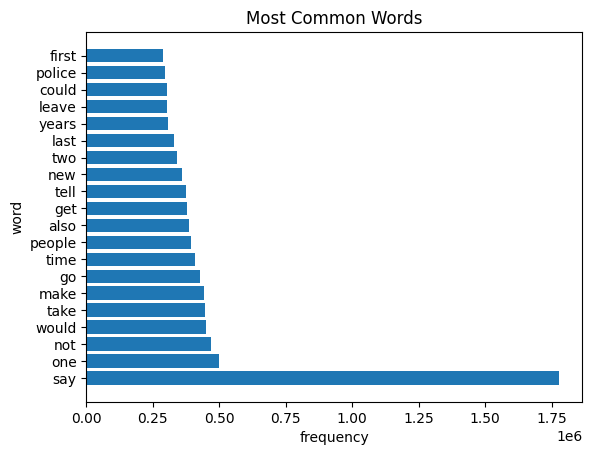

In [26]:
plt.barh(common_words['word'], common_words['frequency'])

plt.xlabel('frequency')
plt.ylabel('word')
plt.title('Most Common Words')

plt.show()

In [27]:
combined_df['article_length'] = combined_df['article'].str.len()

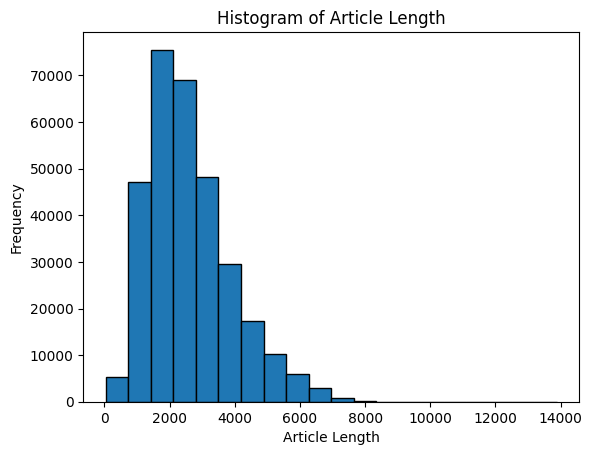

In [28]:
plt.hist(combined_df['article_length'], bins=20, edgecolor='black')
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Histogram of Article Length')
plt.show()

In [29]:
combined_summaries_df['summary_length'] = combined_summaries_df['summary'].str.len()

In [30]:
summaries_filtered_df = combined_summaries_df[combined_summaries_df['summary_length'] < 1250]

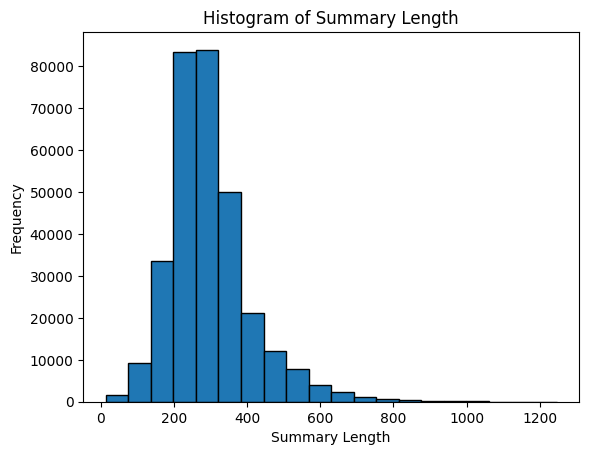

In [31]:
plt.hist(summaries_filtered_df['summary_length'], bins=20, edgecolor='black')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Histogram of Summary Length')
plt.show()

In [32]:
combined_df['article_word_count'] = combined_df['article'].apply(lambda x: len(str(x).split()))

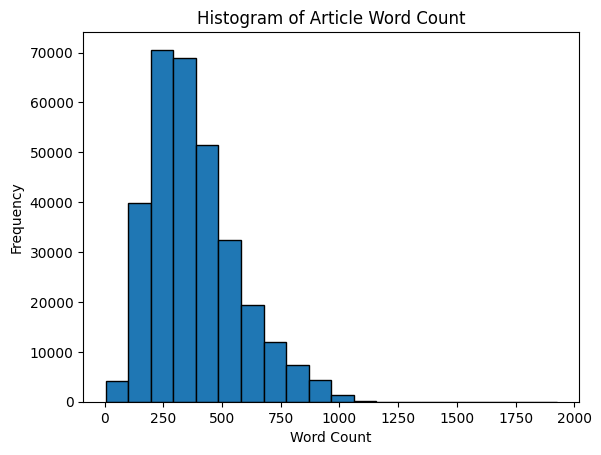

In [33]:
plt.hist(combined_df['article_word_count'], bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Article Word Count')
plt.show()

In [34]:
combined_summaries_df['summary_word_count'] = combined_summaries_df['summary'].apply(lambda x: len(str(x).split()))

In [35]:
summaries_filtered_word_df = combined_summaries_df[combined_summaries_df['summary_word_count'] < 200]

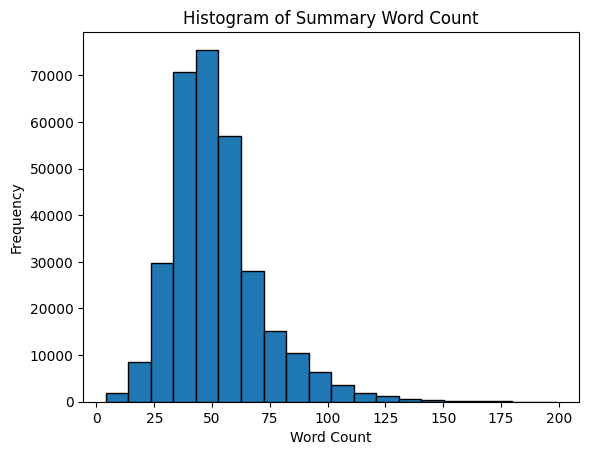

In [36]:
plt.hist(summaries_filtered_word_df['summary_word_count'], bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Summary Word Count')
plt.show()

In [37]:
length_df = words.select(length('word').alias('word_length'))

In [38]:
word_length_count = length_df.groupBy('word_length').count()

In [39]:
pandas_df = word_length_count.toPandas()

Minimum: 1.0
Maximum: 58.0
Median: 25.0


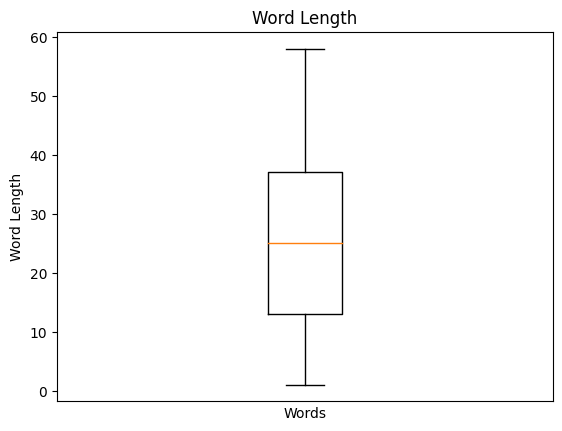

In [46]:
box_filtered_df = pandas_df[pandas_df['count'] > 10]

boxplot = plt.boxplot(box_filtered_df['word_length'])

stats = {
    'min': np.min(boxplot['whiskers'][0].get_ydata()),
    'max': np.max(boxplot['whiskers'][1].get_ydata()),
    'median': np.median(boxplot['medians'][0].get_ydata())
}

print(f"Minimum: {stats['min']}")
print(f"Maximum: {stats['max']}")
print(f"Median: {stats['median']}")

plt.xticks([])

plt.xlabel('Words')
plt.ylabel('Word Length')
plt.title('Word Length')
plt.show()

In [41]:
filtered_df = pandas_df[pandas_df['count'] > 10]

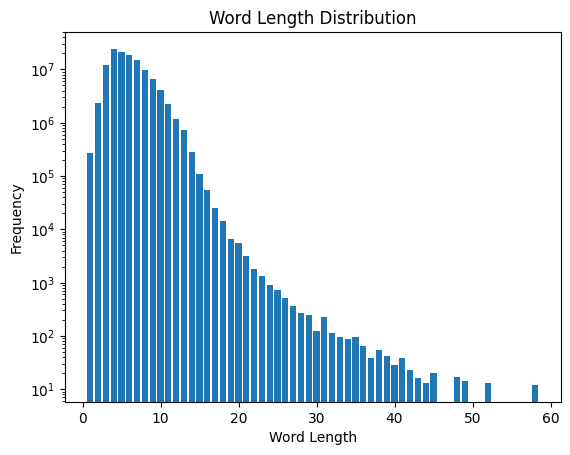

In [42]:
plt.bar(filtered_df['word_length'] , filtered_df['count'])
plt.yscale('log')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution')
plt.show()

In [285]:
combined_df['sentiment'] = combined_df['article'].apply(lambda x: TextBlob(x).sentiment.polarity)

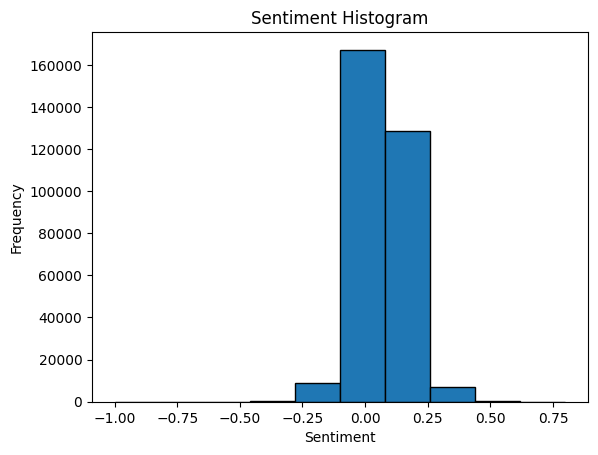

In [286]:
plt.hist(combined_df['sentiment'], bins=10, edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Histogram')
plt.show()

### LDA

In [287]:
lemmatizer = WordNetLemmatizer()

In [288]:
def preprocess_lda(text):

    tokens = word_tokenize(text)
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [289]:
processed_combined_df = combined_df['article'].apply(preprocess_lda)

In [290]:
dictionary = corpora.Dictionary(processed_combined_df)

In [291]:
corpus = [dictionary.doc2bow(tokens) for tokens in processed_combined_df]

In [292]:
number_of_topics = 10
lda_model = models.LdaModel(corpus, num_topics=number_of_topics, id2word=dictionary)

In [293]:
n_top_words = 15
for topic_idx, topic in lda_model.show_topics(num_topics=number_of_topics, num_words=n_top_words, formatted=False):
    top_words = [word for word, _ in topic]
    print(f"Topic {topic_idx}: {','.join(top_words)}")

Topic 0: use,say,find,year,also,per,make,people,could,new,cent,one,food,study,dr
Topic 1: say,car,water,one,take,area,around,build,flight,see,two,park,year,passenger,crash
Topic 2: say,police,court,tell,officer,find,charge,death,two,home,yearold,man,arrest,report,family
Topic 3: say,not,get,go,would,tell,like,think,one,i,child,take,time,is,know
Topic 4: say,mr,would,claim,labour,year,minister,make,last,people,party,pay,government,also,work
Topic 5: say,state,new,per,president,cent,year,house,u,would,obama,million,not,people,clinton
Topic 6: game,league,player,play,season,club,team,win,goal,last,unite,england,score,first,leave
Topic 7: year,show,new,one,star,also,picture,film,make,include,world,look,first,take,london
Topic 8: say,attack,group,kill,force,isi,fight,people,war,state,islamic,u,military,syria,one
Topic 9: say,country,u,china,world,president,russian,international,state,government,russia,official,south,africa,foreign


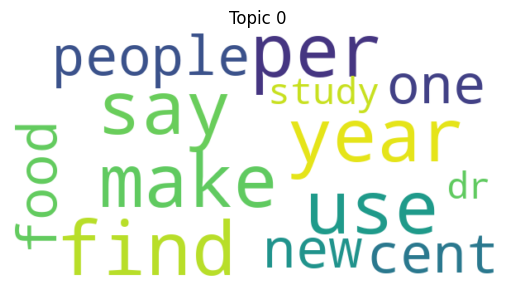

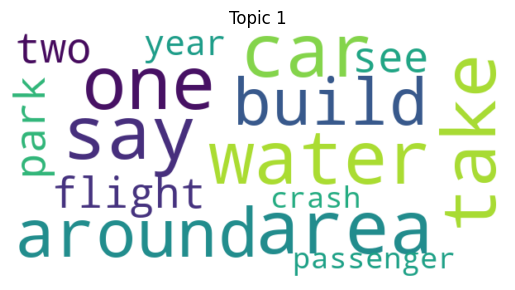

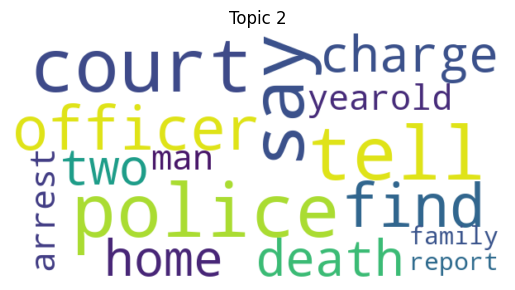

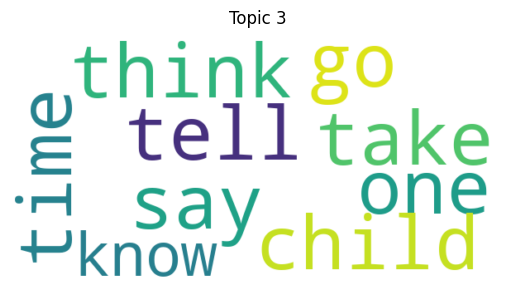

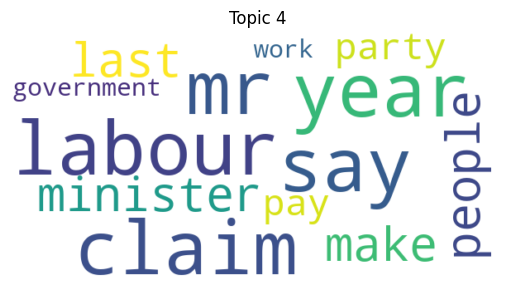

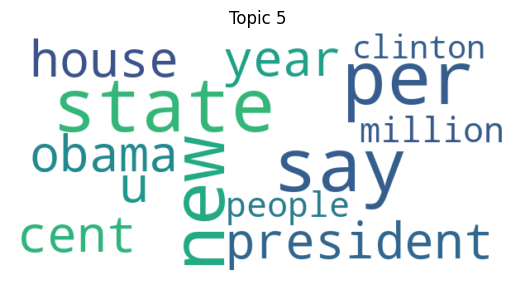

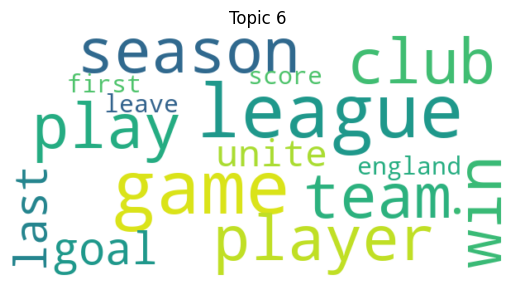

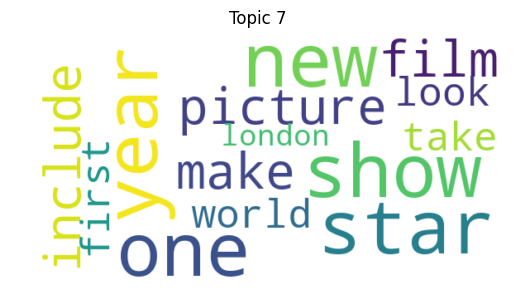

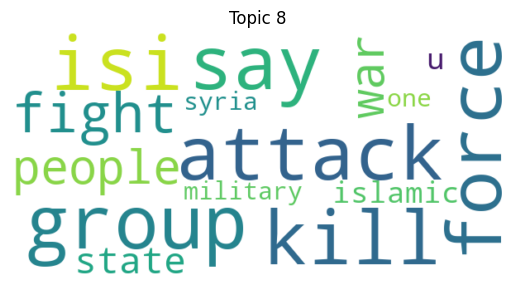

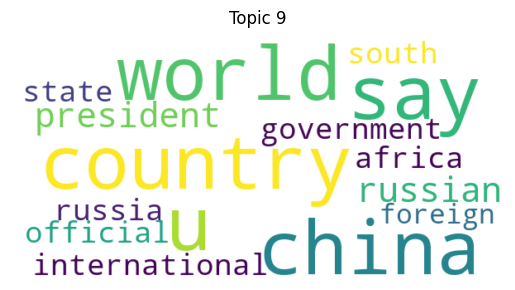

In [294]:
for topic_idx, topic in lda_model.show_topics(num_topics=number_of_topics, num_words=n_top_words, formatted=False):
    top_words = [word for word, _ in topic]
    wordcloud = WordCloud(width=200, height=100,
                        background_color='white',
                        max_words=15,
                        max_font_size=30,
                        scale=3).generate(' '.join(top_words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx}")
    plt.axis("off")
    plt.show()

### NER

In [335]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [336]:
def perform_ner(text):
    sentences = sent_tokenize(text)
    
    tagged_sentences = [pos_tag(word_tokenize(sentence)) for sentence in sentences]
    
    named_entities = []
    for tagged_sentence in tagged_sentences:
        tree = ne_chunk(tagged_sentence)
        named_entities.extend([(entity.label(), ' '.join(c[0] for c in entity.leaves())) for entity in tree if hasattr(entity, 'label')])
    
    return named_entities

In [337]:
current_path = os.getcwd()
folder_name = "named_entities"
print("Current path:", current_path)
new_folder_path = os.path.join(current_path, folder_name)

if os.path.exists(new_folder_path):
    if os.path.isfile(new_folder_path):
        os.remove(new_folder_path)
    else:
        shutil.rmtree(new_folder_path)

print("New Folder Path: ", new_folder_path)
os.makedirs(new_folder_path)

Current path: f:\University of Birmingham\Summer Project\aroha
New Folder Path:  f:\University of Birmingham\Summer Project\aroha\named_entities


In [12]:
unprocessed_articles = pd.concat([train_df[['article','id']], validation_df[['article','id']], test_df[['article','id']]], ignore_index=True)

In [13]:
unprocessed_articles.count()

article    311971
id         311971
dtype: int64

In [14]:
length = len(unprocessed_articles)

print("length of input data: ", length)

batches = [unprocessed_articles[i:i+1000] for i in range(0, length, 1000)]

print("batches created: ", len(batches))

length of input data:  311971
batches created:  312


In [341]:
# Iterate over each batch
for i, batch in enumerate(batches):
    
    print(f"started executing batch {i+1} of {len(batches)}")
    
    batch['named_entities'] = batch['article'].apply(perform_ner)
    
    batch = batch.reset_index(drop=True)
    
    print(f"executed batch {i+1} of {len(batches)}")
    
    file_name = f"batch_{i+1}.parquet"
    output_folder = "named_entities"
    batch.to_parquet(f"{output_folder}/{file_name}")

started executing batch 1 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 1 of 312
started executing batch 2 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 2 of 312
started executing batch 3 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 3 of 312
started executing batch 4 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 4 of 312
started executing batch 5 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 5 of 312
started executing batch 6 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 6 of 312
started executing batch 7 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 7 of 312
started executing batch 8 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 8 of 312
started executing batch 9 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 9 of 312
started executing batch 10 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 10 of 312
started executing batch 11 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 11 of 312
started executing batch 12 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 12 of 312
started executing batch 13 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 13 of 312
started executing batch 14 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 14 of 312
started executing batch 15 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 15 of 312
started executing batch 16 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 16 of 312
started executing batch 17 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 17 of 312
started executing batch 18 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 18 of 312
started executing batch 19 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 19 of 312
started executing batch 20 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 20 of 312
started executing batch 21 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 21 of 312
started executing batch 22 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 22 of 312
started executing batch 23 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 23 of 312
started executing batch 24 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 24 of 312
started executing batch 25 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 25 of 312
started executing batch 26 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 26 of 312
started executing batch 27 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 27 of 312
started executing batch 28 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 28 of 312
started executing batch 29 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 29 of 312
started executing batch 30 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 30 of 312
started executing batch 31 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 31 of 312
started executing batch 32 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 32 of 312
started executing batch 33 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 33 of 312
started executing batch 34 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 34 of 312
started executing batch 35 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 35 of 312
started executing batch 36 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 36 of 312
started executing batch 37 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 37 of 312
started executing batch 38 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 38 of 312
started executing batch 39 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 39 of 312
started executing batch 40 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 40 of 312
started executing batch 41 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 41 of 312
started executing batch 42 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 42 of 312
started executing batch 43 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 43 of 312
started executing batch 44 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 44 of 312
started executing batch 45 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 45 of 312
started executing batch 46 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 46 of 312
started executing batch 47 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 47 of 312
started executing batch 48 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 48 of 312
started executing batch 49 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 49 of 312
started executing batch 50 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 50 of 312
started executing batch 51 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 51 of 312
started executing batch 52 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 52 of 312
started executing batch 53 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 53 of 312
started executing batch 54 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 54 of 312
started executing batch 55 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 55 of 312
started executing batch 56 of 312


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 55601)
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "f:\University of Birmingham\Summer Project\aroha\

executed batch 56 of 312
started executing batch 57 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 57 of 312
started executing batch 58 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 58 of 312
started executing batch 59 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 59 of 312
started executing batch 60 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 60 of 312
started executing batch 61 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 61 of 312
started executing batch 62 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 62 of 312
started executing batch 63 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 63 of 312
started executing batch 64 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 64 of 312
started executing batch 65 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 65 of 312
started executing batch 66 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 66 of 312
started executing batch 67 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 67 of 312
started executing batch 68 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 68 of 312
started executing batch 69 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 69 of 312
started executing batch 70 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 70 of 312
started executing batch 71 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 71 of 312
started executing batch 72 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 72 of 312
started executing batch 73 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 73 of 312
started executing batch 74 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 74 of 312
started executing batch 75 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 75 of 312
started executing batch 76 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 76 of 312
started executing batch 77 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 77 of 312
started executing batch 78 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 78 of 312
started executing batch 79 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 79 of 312
started executing batch 80 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 80 of 312
started executing batch 81 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 81 of 312
started executing batch 82 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 82 of 312
started executing batch 83 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 83 of 312
started executing batch 84 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 84 of 312
started executing batch 85 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 85 of 312
started executing batch 86 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 86 of 312
started executing batch 87 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 87 of 312
started executing batch 88 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 88 of 312
started executing batch 89 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 89 of 312
started executing batch 90 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 90 of 312
started executing batch 91 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 91 of 312
started executing batch 92 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 92 of 312
started executing batch 93 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 93 of 312
started executing batch 94 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 94 of 312
started executing batch 95 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 95 of 312
started executing batch 96 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 96 of 312
started executing batch 97 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 97 of 312
started executing batch 98 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 98 of 312
started executing batch 99 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 99 of 312
started executing batch 100 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 100 of 312
started executing batch 101 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 101 of 312
started executing batch 102 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 102 of 312
started executing batch 103 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 103 of 312
started executing batch 104 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 104 of 312
started executing batch 105 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 105 of 312
started executing batch 106 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 106 of 312
started executing batch 107 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 107 of 312
started executing batch 108 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 108 of 312
started executing batch 109 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 109 of 312
started executing batch 110 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 110 of 312
started executing batch 111 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 111 of 312
started executing batch 112 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 112 of 312
started executing batch 113 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 113 of 312
started executing batch 114 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 114 of 312
started executing batch 115 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 115 of 312
started executing batch 116 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 116 of 312
started executing batch 117 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 117 of 312
started executing batch 118 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 118 of 312
started executing batch 119 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 119 of 312
started executing batch 120 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 120 of 312
started executing batch 121 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 121 of 312
started executing batch 122 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 122 of 312
started executing batch 123 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 123 of 312
started executing batch 124 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 124 of 312
started executing batch 125 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 125 of 312
started executing batch 126 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 126 of 312
started executing batch 127 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 127 of 312
started executing batch 128 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 128 of 312
started executing batch 129 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 129 of 312
started executing batch 130 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 130 of 312
started executing batch 131 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 131 of 312
started executing batch 132 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 132 of 312
started executing batch 133 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 133 of 312
started executing batch 134 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 134 of 312
started executing batch 135 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 135 of 312
started executing batch 136 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 136 of 312
started executing batch 137 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 137 of 312
started executing batch 138 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 138 of 312
started executing batch 139 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 139 of 312
started executing batch 140 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 140 of 312
started executing batch 141 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 141 of 312
started executing batch 142 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 142 of 312
started executing batch 143 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 143 of 312
started executing batch 144 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 144 of 312
started executing batch 145 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 145 of 312
started executing batch 146 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 146 of 312
started executing batch 147 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 147 of 312
started executing batch 148 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 148 of 312
started executing batch 149 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 149 of 312
started executing batch 150 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 150 of 312
started executing batch 151 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 151 of 312
started executing batch 152 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 152 of 312
started executing batch 153 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 153 of 312
started executing batch 154 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 154 of 312
started executing batch 155 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 155 of 312
started executing batch 156 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 156 of 312
started executing batch 157 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 157 of 312
started executing batch 158 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 158 of 312
started executing batch 159 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 159 of 312
started executing batch 160 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 160 of 312
started executing batch 161 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 161 of 312
started executing batch 162 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 162 of 312
started executing batch 163 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 163 of 312
started executing batch 164 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 164 of 312
started executing batch 165 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 165 of 312
started executing batch 166 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 166 of 312
started executing batch 167 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 167 of 312
started executing batch 168 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 168 of 312
started executing batch 169 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 169 of 312
started executing batch 170 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 170 of 312
started executing batch 171 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 171 of 312
started executing batch 172 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 172 of 312
started executing batch 173 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 173 of 312
started executing batch 174 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 174 of 312
started executing batch 175 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 175 of 312
started executing batch 176 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 176 of 312
started executing batch 177 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 177 of 312
started executing batch 178 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 178 of 312
started executing batch 179 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 179 of 312
started executing batch 180 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 180 of 312
started executing batch 181 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 181 of 312
started executing batch 182 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 182 of 312
started executing batch 183 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 183 of 312
started executing batch 184 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 184 of 312
started executing batch 185 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 185 of 312
started executing batch 186 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 186 of 312
started executing batch 187 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 187 of 312
started executing batch 188 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 188 of 312
started executing batch 189 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 189 of 312
started executing batch 190 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 190 of 312
started executing batch 191 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 191 of 312
started executing batch 192 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 192 of 312
started executing batch 193 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 193 of 312
started executing batch 194 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 194 of 312
started executing batch 195 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 195 of 312
started executing batch 196 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 196 of 312
started executing batch 197 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 197 of 312
started executing batch 198 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 198 of 312
started executing batch 199 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 199 of 312
started executing batch 200 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 200 of 312
started executing batch 201 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 201 of 312
started executing batch 202 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 202 of 312
started executing batch 203 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 203 of 312
started executing batch 204 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 204 of 312
started executing batch 205 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 205 of 312
started executing batch 206 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 206 of 312
started executing batch 207 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 207 of 312
started executing batch 208 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 208 of 312
started executing batch 209 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 209 of 312
started executing batch 210 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 210 of 312
started executing batch 211 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 211 of 312
started executing batch 212 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 212 of 312
started executing batch 213 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 213 of 312
started executing batch 214 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 214 of 312
started executing batch 215 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 215 of 312
started executing batch 216 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 216 of 312
started executing batch 217 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 217 of 312
started executing batch 218 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 218 of 312
started executing batch 219 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 219 of 312
started executing batch 220 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 220 of 312
started executing batch 221 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 221 of 312
started executing batch 222 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 222 of 312
started executing batch 223 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 223 of 312
started executing batch 224 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 224 of 312
started executing batch 225 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 225 of 312
started executing batch 226 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 226 of 312
started executing batch 227 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 227 of 312
started executing batch 228 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 228 of 312
started executing batch 229 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 229 of 312
started executing batch 230 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 230 of 312
started executing batch 231 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 231 of 312
started executing batch 232 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 232 of 312
started executing batch 233 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 233 of 312
started executing batch 234 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 234 of 312
started executing batch 235 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 235 of 312
started executing batch 236 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 236 of 312
started executing batch 237 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 237 of 312
started executing batch 238 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 238 of 312
started executing batch 239 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 239 of 312
started executing batch 240 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 240 of 312
started executing batch 241 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 241 of 312
started executing batch 242 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 242 of 312
started executing batch 243 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 243 of 312
started executing batch 244 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 244 of 312
started executing batch 245 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 245 of 312
started executing batch 246 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 246 of 312
started executing batch 247 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 247 of 312
started executing batch 248 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 248 of 312
started executing batch 249 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 249 of 312
started executing batch 250 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 250 of 312
started executing batch 251 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 251 of 312
started executing batch 252 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 252 of 312
started executing batch 253 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 253 of 312
started executing batch 254 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 254 of 312
started executing batch 255 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 255 of 312
started executing batch 256 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 256 of 312
started executing batch 257 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 257 of 312
started executing batch 258 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 258 of 312
started executing batch 259 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 259 of 312
started executing batch 260 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 260 of 312
started executing batch 261 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 261 of 312
started executing batch 262 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 262 of 312
started executing batch 263 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 263 of 312
started executing batch 264 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 264 of 312
started executing batch 265 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 265 of 312
started executing batch 266 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 266 of 312
started executing batch 267 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 267 of 312
started executing batch 268 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 268 of 312
started executing batch 269 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 269 of 312
started executing batch 270 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 270 of 312
started executing batch 271 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 271 of 312
started executing batch 272 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 272 of 312
started executing batch 273 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 273 of 312
started executing batch 274 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 274 of 312
started executing batch 275 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 275 of 312
started executing batch 276 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 276 of 312
started executing batch 277 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 277 of 312
started executing batch 278 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 278 of 312
started executing batch 279 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 279 of 312
started executing batch 280 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 280 of 312
started executing batch 281 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 281 of 312
started executing batch 282 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 282 of 312
started executing batch 283 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 283 of 312
started executing batch 284 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 284 of 312
started executing batch 285 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 285 of 312
started executing batch 286 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 286 of 312
started executing batch 287 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 287 of 312
started executing batch 288 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 288 of 312
started executing batch 289 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 289 of 312
started executing batch 290 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 290 of 312
started executing batch 291 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 291 of 312
started executing batch 292 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 292 of 312
started executing batch 293 of 312
executed batch 293 of 312
started executing batch 294 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)
C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 294 of 312
started executing batch 295 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 295 of 312
started executing batch 296 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 296 of 312
started executing batch 297 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 297 of 312
started executing batch 298 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 298 of 312
started executing batch 299 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 299 of 312
started executing batch 300 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 300 of 312
started executing batch 301 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 301 of 312
started executing batch 302 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 302 of 312
started executing batch 303 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 303 of 312
started executing batch 304 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 304 of 312
started executing batch 305 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 305 of 312
started executing batch 306 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 306 of 312
started executing batch 307 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 307 of 312
started executing batch 308 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 308 of 312
started executing batch 309 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 309 of 312
started executing batch 310 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 310 of 312
started executing batch 311 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 311 of 312
started executing batch 312 of 312


C:\Users\vijay\AppData\Local\Temp\ipykernel_5180\3244868608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['named_entities'] = batch['article'].apply(perform_ner)


executed batch 312 of 312


In [15]:
ner_schema = StructType([
    StructField("article", StringType(), nullable=True),
    StructField("id", StringType(), nullable=True),
    StructField("named_entities", ArrayType(ArrayType(StringType())), nullable=True)
])

ner_df = spark.createDataFrame([], ner_schema)

output_folder = "named_entities"
file_prefix = "batch_"

for i, batch in enumerate(batches):
        file_name = f"{file_prefix}{i+1}.parquet"
        batch_df = spark.read.parquet(f'{output_folder}/{file_name}', header=True, inferSchema=True)
        ner_df = ner_df.union(batch_df)  

In [16]:
explode_df = ner_df.select(explode("named_entities").alias("entity"))

In [17]:
entities_df = explode_df.withColumn("entity_type", col("entity").getItem(0))
entities_df = entities_df.withColumn("entity_name", col("entity").getItem(1))

In [18]:
entities_count_df = entities_df.select("entity_type", "entity_name").groupBy("entity_type", "entity_name").count()

In [19]:
window_spec = Window.partitionBy("entity_type").orderBy(desc("count"))

entities_rank_df = entities_count_df.withColumn("rank", row_number().over(window_spec))

top_entities_df = entities_rank_df.filter(col("rank") <= 100)

In [20]:
top_entities = top_entities_df.select("entity_type", "entity_name", "count").toPandas()

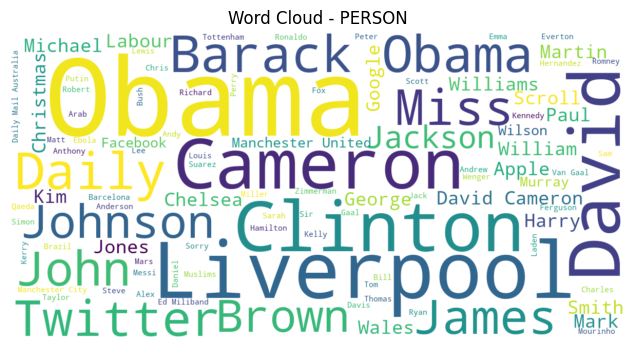

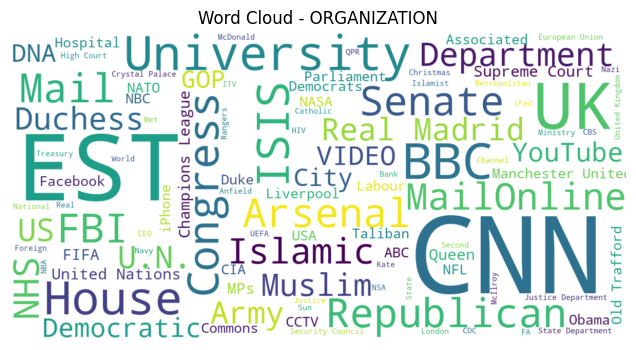

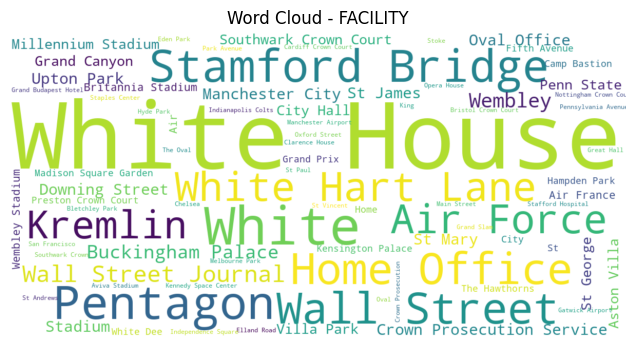

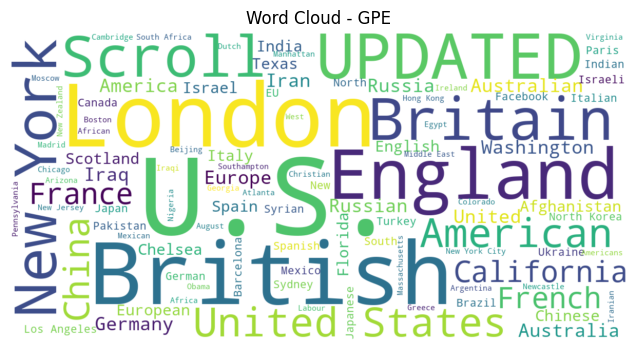

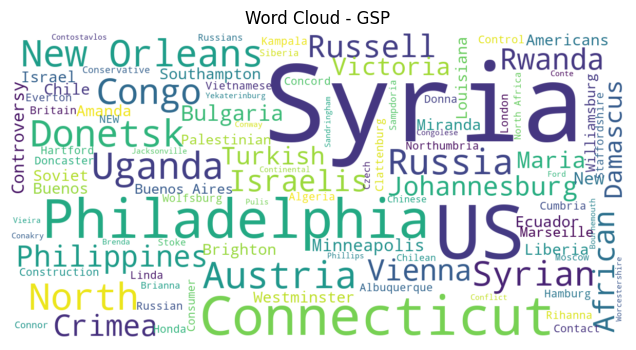

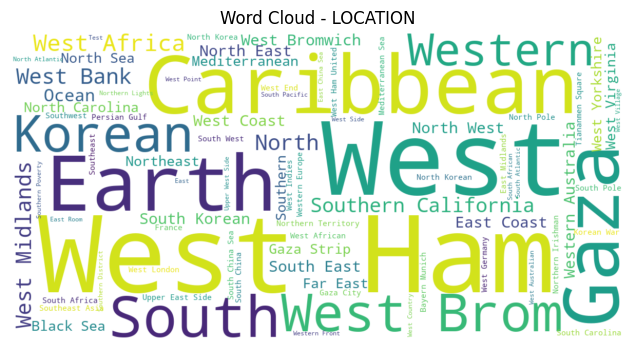

In [21]:
for entity_type in top_entities["entity_type"].unique():
    entities = top_entities[top_entities["entity_type"] == entity_type]

    wordcloud_data = dict(zip(entities["entity_name"], entities["count"]))

    wordcloud = WordCloud(width=400, height=200,
                        background_color='white',
                        max_words=100,
                        max_font_size=70,
                        scale=3).generate_from_frequencies(wordcloud_data)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud - {entity_type}")
    plt.axis("off")
    plt.show()